# Séance 4: Détermination de la qualité d'une bonne trajectoire

Le but de la séance sera de déterminer en quoi une trajectoire sera de bonne qualité, en fonction de différents paramètres, tels que par exemple le temps et l'espace.

Nous allons nous intéresser à l'ID 11, car c'est le seul où on peut y voir un déplacement, mais aussi un nombre d'enregistrements correct.

In [10]:
import pandas as pd
import gmaps
import gmaps.datasets
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import statistics
import glob

from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.image as image
import matplotlib.pyplot as plt


Importons tout d'abord nos données nettoyées de la dernière fois.
On prenait la donnée GPS la plus utilisée pour chaque intervalle d'une minute

In [2]:
df = pd.read_csv("Data/Privamov/id11.txt",sep="\t", header=None,  names = ["Id", "DateTime", "Latitude", "Longitude"])
coord11 = df[["Latitude", "Longitude"]]
;

''

In [3]:
from geopy.distance import vincenty
liste = []
for i in range(1, len(df)):
    deltaT = datetime.strptime(df.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(df.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
    if deltaT.total_seconds() == 0:
        continue
    iterloc1 = (df.Latitude.iloc[i], df.Longitude.iloc[i])
    iterloc2 = (df.Latitude.iloc[i], df.Longitude.iloc[i-1])
    speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
    liste.append(speed)

Affichons maintenant la vitesse avec les données nettoyées

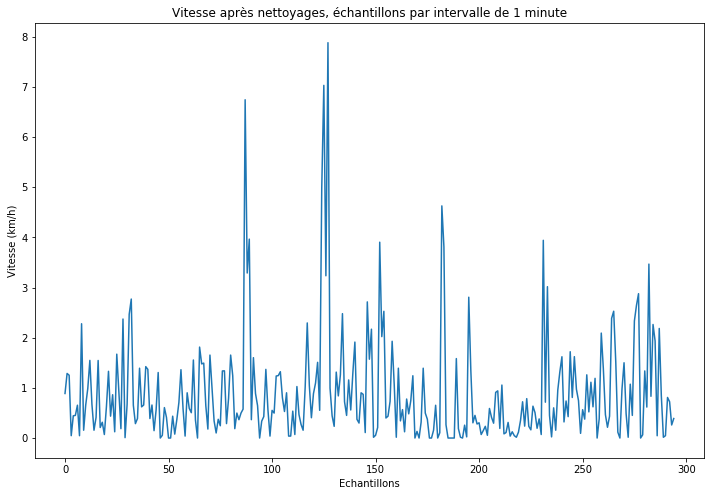

7.880845590881933

In [4]:
plt.figure(figsize=(12,8))
plt.xlabel('Echantillons')
plt.ylabel('Vitesse (km/h)')
plt.plot(liste)
plt.title("Vitesse après nettoyages, échantillons par intervalle de 1 minute")
plt.show()
max(liste)

#### Remarque
Nous avons néanmoins remarqué quelques points négatifs avec l'algorithme de nettoyage utilisé.
L'algorithme ne prend pas vraiment en compte les intervalles de temps où les données sont manquantes, ce qui peut fausser les trajectoires.
Il nous faut donc changer l'algorithme afin que celui-ci prenne en compte les intervalles où il manque des données.

### Définition du nouvel algorithme

In [117]:
def cleanMethodMinutes(frameParam, delta):
    listeLongitude = []
    listeLatitude = []
    listeTemps = []
    listeLongitude2 = []
    listeLatitude2 = []
    localDf = frameParam

    current = datetime.strptime(localDf.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = delta)

    for i in range(1, len(localDf)):
        if datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
            listeLongitude2 = []
            listeLatitude2 = []
            listeLongitude2.append(localDf.Longitude.iloc[i])
            listeLatitude2.append(localDf.Latitude.iloc[i])
        else:
            listeTemps.append(localDf.DateTime.iloc[i])
            current = current + timedelta(minutes = delta)
            listeLongitude.append(statistics.mode(listeLongitude2))
            listeLatitude.append(statistics.mode(listeLatitude2))

    localDf = pd.DataFrame(
        {'DateTime': listeTemps,
         'Longitude': listeLongitude,
         'Latitude': listeLatitude
        })
    print(len(listeTemps))
    print(len(listeLongitude))
    print(len(listeLatitude))

    
    return localDf

In [133]:
def cleanMethodMinutes(frameParam, delta):
    listeLongitude = []
    listeLatitude = []
    listeTemps = []
    listeLongitude2 = []
    listeLatitude2 = []
    localDf = frameParam

    current = datetime.strptime(localDf.DateTime.iloc[0], '%Y-%m-%d %H:%M:%S.%f') + timedelta(minutes = delta)

    for i in range(0, len(localDf)):
        if datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') < current:
            listeLongitude2.append(localDf.Longitude.iloc[i])
            listeLatitude2.append(localDf.Latitude.iloc[i])
            currentLongitude = localDf.Longitude.iloc[i]
            currentLatitude = localDf.Latitude.iloc[i]
        elif datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') > current + timedelta(minutes = delta):
            listeTemps.append(localDf.DateTime.iloc[i])
            listeLongitude.append(currentLongitude)
            listeLatitude.append(currentLatitude)
            current = current + timedelta(minutes = delta)
        else:
            listeTemps.append(localDf.DateTime.iloc[i])
            current = current + timedelta(minutes = delta)
            listeLongitude.append(max(set(listeLongitude2), key = listeLongitude2.count))
            listeLatitude.append(max(set(listeLatitude2), key = listeLatitude2.count))
            listeLongitude2 = []
            listeLatitude2 = []

    localDf = pd.DataFrame(
        {'DateTime': listeTemps,
         'Longitude': listeLongitude,
         'Latitude': listeLatitude
        })
    print(len(listeTemps))
    print(len(listeLongitude))
    print(len(listeLatitude))

    
    return localDf

Cet algorithme est mieux dans la mesure où il laisse les intervalles de temps. Ainsi, il y aura des poi

In [146]:
def showSpeedGraph(localDf, delta, unit):
    liste = []
    for i in range(10, len(localDf)):
        deltaT = datetime.strptime(localDf.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(localDf.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
        if deltaT.total_seconds() == 0:
            continue
        iterloc1 = (localDf.Latitude.iloc[i], localDf.Longitude.iloc[i])
        iterloc2 = (localDf.Latitude.iloc[i-1], localDf.Longitude.iloc[i-1])
        speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
        liste.append(speed)


    plt.figure(figsize=(12,8))
    plt.xlabel('Echantillons')
    plt.ylabel('Vitesse (km/h)')
    plt.plot(liste)
    plt.title("Vitesse après nettoyages, échantillons par intervalle de "+ str(delta) + " " + unit+ "(s)" )
    plt.show()
    return liste

In [8]:
path = "Data/Privamov/"
allFiles = glob.glob(path + "privamov*")
frame = pd.DataFrame()
list_= []

for file_ in allFiles:
    df = pd.read_csv(file_,sep="\t", header=None,  names = ["Id", "DateTime", "Longitude", "Latitude"])
    list_.append(df)
frame = pd.concat(list_)
frame = frame.sort_values(by="DateTime")
frame.head()

,Id,DateTime,Longitude,Latitude
0,11,2014-12-07 05:20:23.792,4.871210,45.776037
1,1,2014-12-07 05:20:24.282,-97.750252,30.257248
2,1,2014-12-07 05:20:24.305,-97.750252,30.257248
3,11,2014-12-07 05:20:24.769,4.871210,45.776037
4,11,2014-12-07 05:20:24.789,4.871210,45.776037


82
82
82


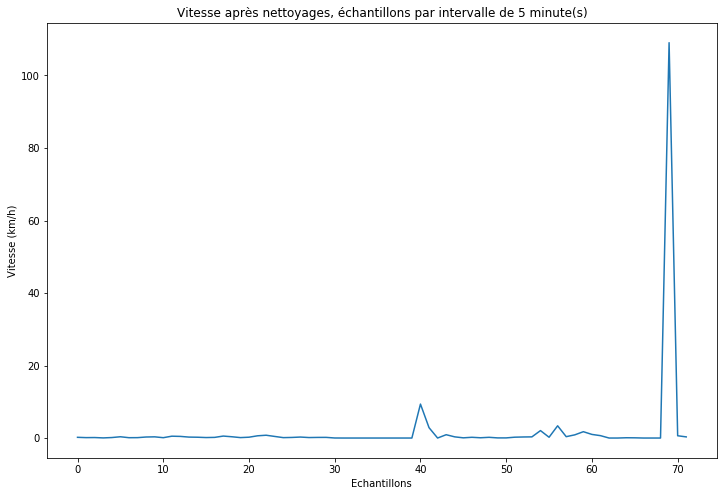

[0.19662608476516863,
 0.1137530043792359,
 0.13489038508413767,
 0.03575019757648148,
 0.13437236571257927,
 0.351699496866273,
 0.09348182035929455,
 0.10948420498808903,
 0.2812594761284783,
 0.3296855583231641,
 0.09701422629097481,
 0.507101129437197,
 0.44970357430496044,
 0.25844800543557217,
 0.22128715469504676,
 0.133793549212445,
 0.18035604327288315,
 0.5399745818812582,
 0.3531284078647836,
 0.1210871025931147,
 0.22989881877203766,
 0.6155870794065528,
 0.772422420356045,
 0.4401450509587875,
 0.11167901509264384,
 0.1636843456742563,
 0.26901110173875364,
 0.13376712414461045,
 0.1703460037436399,
 0.18087706377669135,
 0.012503355096473422,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.363104937896919,
 2.858501862525843,
 0.0,
 0.9154544882760266,
 0.32349175244067774,
 0.05727231037745379,
 0.20460355117602344,
 0.07495547678408906,
 0.19837287606189055,
 0.03686569637125802,
 0.03677144828385727,
 0.2319543038928625,
 0.29027609304428786,
 0.32056887143889

In [147]:
test = cleanMethodMinutes(frame[frame["Id"] == 11], 5)
showSpeedGraph(test, 5, "minute")

In [143]:
liste = []
listeTemps= []
listeLong = []
listeLat = []
for i in range(1, len(test)):
    deltaT = datetime.strptime(test.DateTime.iloc[i], '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(test.DateTime.iloc[i-1], '%Y-%m-%d %H:%M:%S.%f')
    if deltaT.total_seconds() == 0:
        continue
    iterloc1 = (test.Latitude.iloc[i], test.Longitude.iloc[i])
    iterloc2 = (test.Latitude.iloc[i-1], test.Longitude.iloc[i-1])
    speed = (vincenty(iterloc1, iterloc2).kilometers) / (deltaT.total_seconds() / 3600)
    liste.append(speed)
    listeTemps.append(deltaT.total_seconds()/3600)
    listeLong.append(test.Longitude.iloc[i])
    listeLat.append(test.Latitude.iloc[i])
listeTemps

[5.833333333333334e-06,
 0.007500833333333333,
 0.08336888888888888,
 0.08329666666666667,
 0.08333499999999999,
 0.08333361111111111,
 0.0833325,
 0.08360277777777779,
 0.08309861111111111,
 0.08333388888888889,
 0.10305583333333333,
 0.06361027777777778,
 0.08333388888888889,
 0.08333277777777777,
 0.08333416666666667,
 0.08333333333333333,
 0.08333333333333333,
 0.08333333333333333,
 0.08333305555555556,
 0.08333333333333333,
 0.08333333333333333,
 0.08333361111111111,
 0.08333305555555556,
 0.0833325,
 0.08333277777777777,
 0.08333499999999999,
 0.08333333333333333,
 0.08333333333333333,
 0.08333333333333333,
 0.08333305555555556,
 0.08333361111111111,
 0.08333611111111111,
 0.08333055555555556,
 0.08333333333333333,
 0.08333333333333333,
 0.0833736111111111,
 0.08329305555555556,
 0.0833325,
 0.08334027777777778,
 0.9096372222222222,
 6.3888888888888885e-06,
 0.00027055555555555557,
 7.777777777777777e-06,
 0.00027,
 7.222222222222222e-06,
 0.0002708333333333333,
 9.16666666666666

In [83]:
abc = [1, 2 ,3]
max(set(abc), key = abc.count)

1

In [103]:
test

,DateTime,Latitude,Longitude
0,2014-12-07 05:34:56.772,45.775848,4.871315
1,2014-12-07 05:34:56.793,45.775873,4.871047
2,2014-12-07 05:35:23.796,45.775907,4.871082
3,2014-12-07 05:40:23.924,45.775792,4.871420
4,2014-12-07 05:45:23.792,45.775882,4.871238
5,2014-12-07 05:50:23.798,45.775755,4.871782
6,2014-12-07 05:55:23.799,45.775650,4.871460
7,2014-12-07 06:00:23.796,45.775870,4.871567
8,2014-12-07 06:05:24.766,45.775912,4.871435
9,2014-12-07 06:10:23.921,45.775873,4.871098


In [12]:
coord11 = test[["Latitude", "Longitude"]]

%matplotlib inline

im = image.imread('Images/map11.png')

def fct(x):
    coord11_dyn = coord11.iloc[0:x]
    lat_coord11_dyn = coord11_dyn['Longitude'].values
    long_coord11_dyn = coord11_dyn['Latitude'].values
    plt.figure(figsize=(10,10))
    #plt.xlim(0.0035, 0.0070)
    #plt.ylim(4.867,4.873)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.plot(lat_coord11_dyn, long_coord11_dyn)
    plt.xlim(4.867,4.873)
    plt.ylim(45.7735, 45.7770)
    plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
    plt.show()
    
interactive_plot = interactive(fct, x=(1, len(coord11)))
#plt.imshow(im, aspect='auto', extent=(4.866, 4.873, 45.7725, 45.7776), zorder=-1)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=41, description='x', max=82, min=1), Output()), _dom_classes=('widget-interact',))

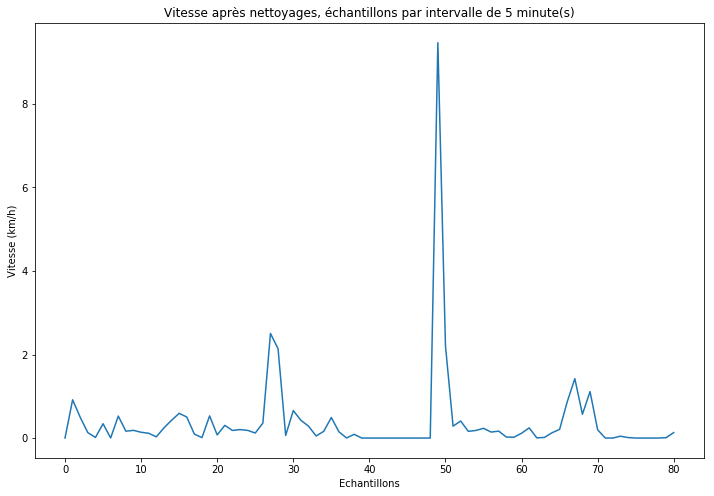

ValueError: If using all scalar values, you must pass an index

In [22]:
liste = showSpeedGraph(test, 5, "minute")
vit = pd.DataFrame({'vitesses':liste})
vit